In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

In [3]:
survey_data = fetch_openml(data_id=534, as_frame=True)

In [4]:
survey_data.data.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


In [5]:
survey_data.data.describe()

,EDUCATION,EXPERIENCE,AGE
count,534.000000,534.000000,534.000000
mean,13.018727,17.822097,36.833333
std,2.615373,12.379710,11.726573
min,2.000000,0.000000,18.000000
25%,12.000000,8.000000,28.000000
50%,12.000000,15.000000,35.000000
75%,15.000000,26.000000,44.000000
max,18.000000,55.000000,64.000000


In [6]:
survey = survey_data.data.copy()
survey['WAGE'] = survey_data.target

In [7]:
survey.isnull().sum()

EDUCATION     0
SOUTH         0
SEX           0
EXPERIENCE    0
UNION         0
AGE           0
RACE          0
OCCUPATION    0
SECTOR        0
MARR          0
WAGE          0
dtype: int64

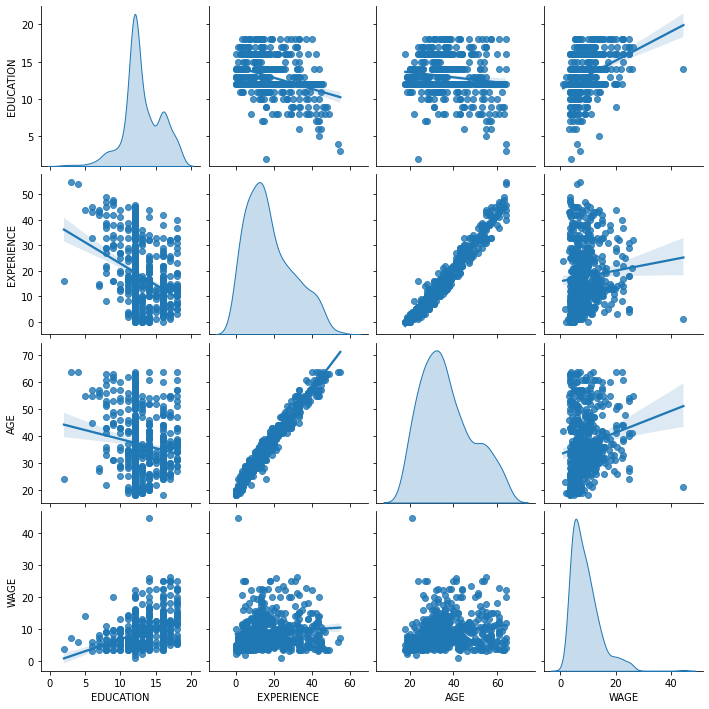

In [8]:
import seaborn as sns
sns.pairplot(survey, kind="reg", diag_kind="kde")

In [9]:
survey.corr()


,EDUCATION,EXPERIENCE,AGE,WAGE
EDUCATION,1.000000,-0.352676,-0.150019,0.381922
EXPERIENCE,-0.352676,1.000000,0.977961,0.087060
AGE,-0.150019,0.977961,1.000000,0.176967
WAGE,0.381922,0.087060,0.176967,1.000000


In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

categorical_features = ["SOUTH", "SEX", "UNION", "RACE", "OCCUPATION", "SECTOR", "MARR"]


preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_features),
     remainder="passthrough",
    verbose_feature_names_out=False
)
X = preprocessor.fit_transform(survey_data.data)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, survey_data.target, test_size=0.25)


In [12]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

Ridge()

In [13]:
from sklearn.metrics import mean_squared_error
y_hat_ridge = ridge_model.predict(X_test)
mean_squared_error(y_test, y_hat_ridge)

23.879452023394425

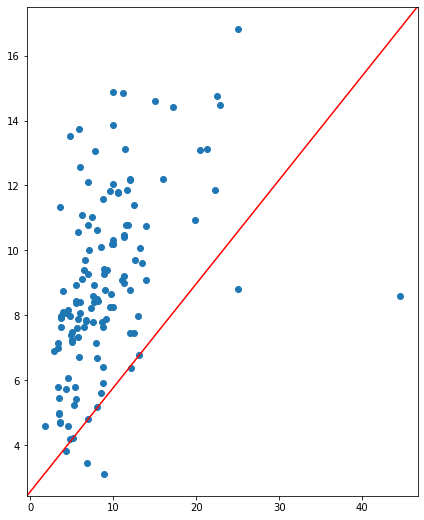

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,9))
plt.scatter(y_test, y_hat_ridge)
ax.plot([0,1], [0,1], transform=ax.transAxes, color="red")

In [15]:
ridge_model.coef_

array([-0.48071261,  2.41232575, -1.37195246, -0.09294716, -0.38033534,
        0.47328251, -0.61539918,  2.11387018, -0.56087683,  1.04546864,
       -1.19761777, -0.78544504,  0.28801815,  0.2848087 , -0.57282685,
       -0.44001957,  0.91097271,  0.29147764, -0.20045408])

In [16]:
coef_names = preprocessor.get_feature_names_out()
coefficients = pd.DataFrame(data=ridge_model.coef_, index=coef_names, columns=["Coefficients"])

In [17]:
coefficients

,Coefficients
SOUTH_yes,-0.480713
SEX_male,2.412326
UNION_not_member,-1.371952
RACE_Hispanic,-0.092947
RACE_Other,-0.380335
RACE_White,0.473283
OCCUPATION_Clerical,-0.615399
OCCUPATION_Management,2.113870
OCCUPATION_Other,-0.560877
OCCUPATION_Professional,1.045469


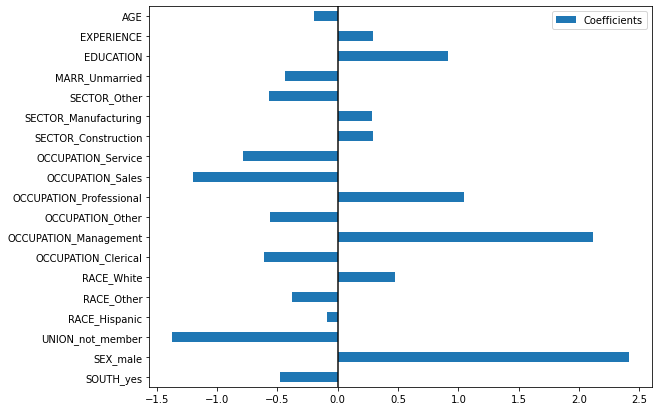

In [18]:
fig, ax = plt.subplots(figsize=(9,7))
coefficients.plot(kind="barh", ax=ax)
plt.axvline(color="0.05")

In [19]:
from sklearn.linear_model import LassoCV

lasso_cv_model = LassoCV(alphas=np.logspace(-10, 10, 21), max_iter=100000)
lasso_cv_model.fit(X_train, y_train)
lasso_cv_model.get_params()

{'alphas': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
 'copy_X': True,
 'cv': None,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 100000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

In [20]:
lasso_cv_model.alpha_


0.01

In [21]:
y_hat_lasso = lasso_cv_model.predict(X_test)
mean_squared_error(y_test, y_hat_lasso)

23.94609782049517

In [22]:
coefficients_lasso = pd.DataFrame(data=lasso_cv_model.coef_, index=coef_names, columns=["Coefficients"])


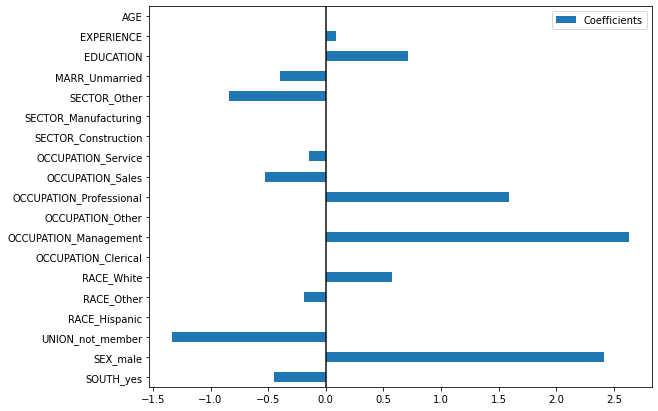

In [23]:
fig, ax = plt.subplots(figsize=(9,7))
coefficients_lasso.plot(kind="barh", ax=ax)
plt.axvline(color="0.05")

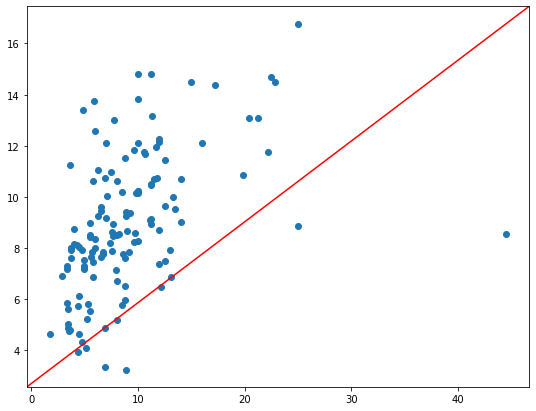

In [30]:
fig, ax = plt.subplots(figsize=(9,7))
plt.scatter(y_test, y_hat_lasso)
ax.plot([0,1], [0,1],transform=ax.transAxes, color="red")

ValueError: x and y must be the same size

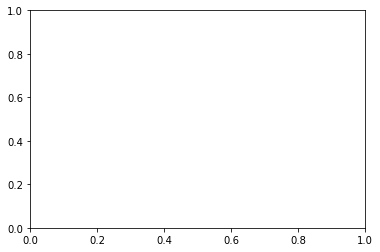